In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd '/content/gdrive/MyDrive/segnet'
! ls

/content/gdrive/MyDrive/segnet
data  segnet.ipynb


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from skimage.io import imread,imshow
from skimage.transform import resize
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
#import Augmentor
import cv2

In [5]:
from keras.models import Model,Sequential
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Input, merge, Conv2D,Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import ReduceLROnPlateau, TensorBoard, Callback
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.losses import binary_crossentropy
from keras import backend as K

In [6]:
IMG_ROW = IMG_COL=64
IMG_CHANNEL = 3
TRAIN_IMG_DIR = '/content/gdrive/MyDrive/segnet/data/image/'
TRAIN_MASK_DIR = '/content/gdrive/MyDrive/segnet/data/lable/'

In [7]:
def get_img_mask_array(imgpath,maskpath):
    img=imread(imgpath)[:,:,:IMG_CHANNEL]
    img=resize(img,(IMG_ROW,IMG_COL),mode='constant',
               preserve_range=True)
    mask=np.zeros((IMG_ROW,IMG_COL,1),dtype=np.bool)
    mask_=imread(maskpath)
    mask_=np.expand_dims(resize(mask_,(IMG_ROW,IMG_COL),
                                mode='constant',preserve_range=True),
                         axis=-1)
    mask=np.maximum(mask,mask_)
    mask1=[]
    for i in range(len(mask)):
        arr1=[]
        for j in range(len(mask[i])):
            if(mask[i][j]==0.):
                arr1.append(1)
                arr1.append(0)
            else:
                arr1.append(0)
                arr1.append(1)
        mask1.append(np.asarray(arr1))
    mask1=np.asarray(mask1)
    mask=mask1.reshape((IMG_ROW*IMG_COL,2))
    return np.asarray(img),np.asarray(mask)

In [8]:
imgarray=[]
maskarray=[]
for path in os.listdir(TRAIN_IMG_DIR):
    #print(i)
    if(os.path.isfile(TRAIN_IMG_DIR + path)):
        img,mask=get_img_mask_array(TRAIN_IMG_DIR + path,TRAIN_MASK_DIR + path)
        imgarray.append(img)
        maskarray.append(mask)
print(np.asarray(imgarray).shape)
print(np.asarray(maskarray).shape)

(525, 64, 64, 3)
(525, 4096, 2)


In [9]:
def build_model(img_w, img_h, filters):
    n_labels = 2

    kernel = 3

    encoding_layers = [
        Conv2D(64, (kernel, kernel), input_shape=(img_h, img_w, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),
    ]

    autoencoder =Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)

    decoding_layers = [
        UpSampling2D(),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(n_labels, (1, 1), padding='valid', activation="sigmoid"),
        BatchNormalization(),
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    autoencoder.add(Reshape((n_labels, img_h * img_w)))
    autoencoder.add(Permute((2, 1)))
    autoencoder.add(Activation('softmax'))

    #with open('model_5l.json', 'w') as outfile:
    #    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))
    autoencoder.summary()
    return autoencoder

In [11]:
model = build_model(IMG_ROW,IMG_COL,10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0

In [12]:
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
callbacks=[
    EarlyStopping(patience=20, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(patience=5, monitor='val_loss', verbose=1),
    ModelCheckpoint('model.h5', save_best_only=True)
]
history=model.fit(np.asarray(imgarray), np.asarray(maskarray), epochs=200,
                  validation_split=0.2, callbacks=callbacks)

Epoch 1/200
14/14 [==============================] - 21s 527ms/step - loss: 0.6773 - accuracy: 0.6411 - val_loss: 0.6930 - val_accuracy: 0.6156 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 5s 350ms/step - loss: 0.4218 - accuracy: 0.8583 - val_loss: 0.6918 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 5s 350ms/step - loss: 0.3770 - accuracy: 0.8873 - val_loss: 0.6885 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 5s 348ms/step - loss: 0.3597 - accuracy: 0.8938 - val_loss: 0.6818 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 5s 344ms/step - loss: 0.3513 - accuracy: 0.8956 - val_loss: 0.6717 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 5s 346ms/step - loss: 0.3447 - accuracy: 0.8965 - val_loss: 0.6581 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 5s 347ms/s

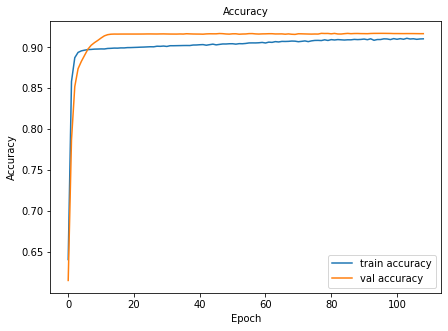

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title(label = 'Accuracy', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('accuracy')

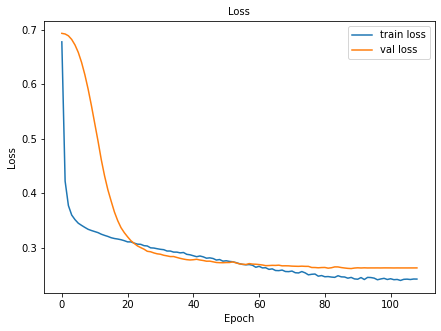

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title(label = 'Loss', fontsize = 10, color = "black")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss')

In [21]:
predict_result = model.predict(np.asarray(imgarray))
predict_mask = predict_result.reshape((len(predict_result),IMG_ROW,IMG_COL,2))
maskarray = np.asarray(maskarray).reshape((len(maskarray),IMG_ROW,IMG_COL,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


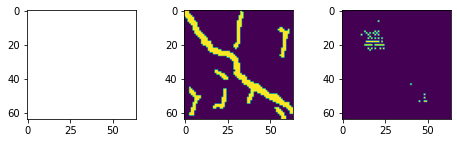

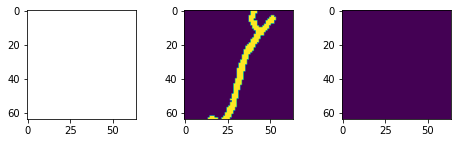

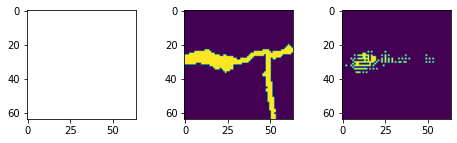

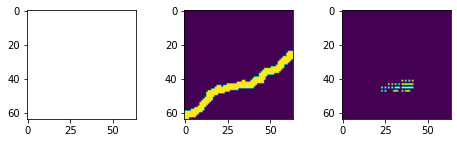

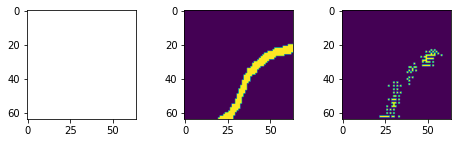

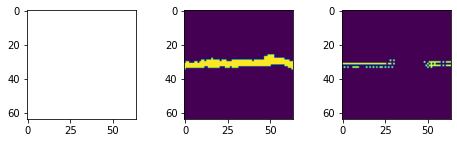

In [24]:
for i in range(6):
    rnd_id = random.randint(0,len(imgarray)-1)
    f,ax = plt.subplots(1,3,figsize=(8,2))
    axes = ax.flatten()
    j=0
    for ax in axes:
        if(j==0):
            ax.imshow(imgarray[rnd_id])
        elif(j==1):
            ax.imshow(np.argmax(maskarray[rnd_id],axis=-1))
        else:
            ax.imshow(np.argmax(predict_mask[rnd_id],axis=-1))
        j+=1